In [605]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import requests
import base64
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

USERNAME = 'test1294'
CHALLENGE_URL = 'https://captcha.delorean.codes/u/{}/challenge'.format(
    USERNAME)

ALPHABET = list('abcdefghijklmnopqrstuvwxyz0123456789')


def get_captchas():
    return requests.get(CHALLENGE_URL).json()['images']


def decode_image(captcha):
    return plt.imread(io.BytesIO(base64.b64decode(captcha['jpg_base64'])), format='jpg')


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


def gray2bw(gray, threshold=200):
    return np.where(gray < threshold, 0, 255)


def get_background(cache=[]):
    if cache:
        return cache[0]
    captchas = get_captchas()
    img = np.average([rgb2gray(decode_image(c))
                      for c in captchas[:300]], axis=0)
    img = gray2bw(img)
    cache.append(img)
    return img


def preprocess(captcha):
    return gray2bw(rgb2gray(decode_image(captcha))) ^ get_background()

In [606]:
def show(img):
    img = np.squeeze(img)
    if max(img.shape) < 50:
        plt.figure(figsize=(1, 1))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

In [607]:
captchas = get_captchas()

In [608]:
w = 100
h = 50

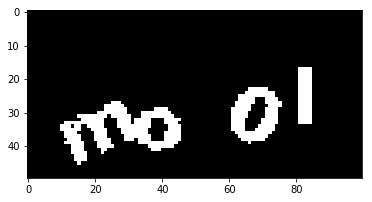

In [609]:
image = preprocess(captchas[1])
show(image)

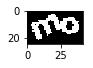

(25, 42)


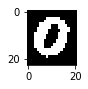

(23, 21)


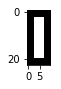

(23, 10)


[None, None, None]

In [610]:
def patch_to_image(patch, margin=3):
    min_x = min(x for (x, y) in patch)
    max_x = max(x for (x, y) in patch)
    min_y = min(y for (x, y) in patch)
    max_y = max(y for (x, y) in patch)
    w = max_y - min_y + 1 + 2 * margin
    h = max_x - min_x + 1 + 2 * margin
    mask = np.zeros((h, w))
    for (x, y) in patch:
        nx = margin + x - min_x
        ny = margin + y - min_y
        mask[nx, ny] = 1
    return mask
    
    
def show_patch(patch, margin=3):
    mask = patch_to_image(patch)
    show(mask)
    print(mask.shape)
    

def segment(image, step=2, min_patch_size=10):
    h, w = image.shape
    
    starts = []
    for y in range(w):
        for x in range(h):
            if image[x, y]:
                starts.append((x, y))
    
    deltas = list(range(-step, step + 1))
    patches = []
    seen = set()
    for start in starts:
        if start in seen:
            continue
        seen.add(start)
        queue = collections.deque()
        queue.append(start)
        patch = []
        while queue:
            x, y = queue.pop()
            patch.append((x, y))
            for dx in deltas:
                for dy in deltas:
                    nx, ny = x + dx, y + dy
                    if (0 <= nx < h and 
                            0 <= ny < w and
                            image[nx, ny] and
                            (nx, ny) not in seen):
                        seen.add((nx, ny))
                        queue.append((nx, ny))
        if len(patch) >= min_patch_size:
            patches.append(patch)
    return patches


[show_patch(patch) for patch in segment(image)]

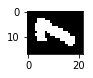

In [611]:
nn_size = 30
max_rotation = 60
fonts = ['fonts/OpenSans-Bold.ttf', 'fonts/Museo_Slab_500_2.otf']

def render_letter(letter, draw_line=True):
    rotation = np.random.randint(-max_rotation, max_rotation + 1)
    font = ImageFont.truetype(np.random.choice(fonts), 24)
    patch = Image.new('L', font.getsize(letter))
    draw = ImageDraw.Draw(patch)
    draw.text((0, 0), letter, font=font, fill='white')
    if draw_line:
        w = np.random.randint(1, 4)
        x0 = np.random.randint(patch.height)
        x1 = np.random.randint(patch.height)
        y0 = np.random.randint(patch.width)
        y1 = np.random.randint(patch.width)
        draw.line([(x0, y0), (x1, y1)], width=w, fill='black')
    img = patch.rotate(rotation, expand=True)
    img = np.where(np.asarray(img) < 5, 0, 255)
    patches = segment(img)
    if len(patches) != 1:
        return render_letter(letter)
    return patch_to_image(patches[0])

show(render_letter('1'))

In [612]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, nn_size, nn_size)
else:
    input_shape = (nn_size, nn_size, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1384576   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [613]:
model.load_weights('models/model.h5')

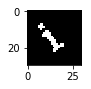

In [619]:
class_to_letter = ['?'] + ALPHABET
num_classes = len(class_to_letter)
letter_to_class = {
    letter: i for i, letter in enumerate(class_to_letter)
}


def resize(image):
    h, w = image.shape
    w = min(nn_size, w)
    h = min(nn_size, h)
    x = np.random.randint(nn_size - h + 1)
    y = np.random.randint(nn_size - w + 1)
    new_image = np.zeros((nn_size, nn_size))
    new_image[x:x + h, y:y + w] = image[:h, :w]
    return np.reshape(new_image, input_shape)
    

def generate_example(letter=None):
    if letter is None:
        letter = np.random.choice(ALPHABET)
    image = render_letter(letter)
    x = resize(image)
    y = keras.utils.to_categorical(letter_to_class[letter], num_classes=num_classes)
    y = np.squeeze(y)
    return x, y


def next_batch(batch_size=32):
    x, y = list(zip(*[generate_example() for i in range(batch_size)]))
    return np.stack(x), np.stack(y)


def batch_generator():
    while True:
        yield next_batch()

    
x, y = next_batch()
show(x[0])

In [620]:
model.fit_generator(
    batch_generator(),
    steps_per_epoch=100,
    epochs=10,
    validation_data=batch_generator(),
    validation_steps=30)

Epoch 1/10
100/100 [==============================] - 29s - loss: 1.6092 - acc: 0.5537 - val_loss: 0.6336 - val_acc: 0.8198

In [621]:
model.save('models/model_2_fonts.h5')

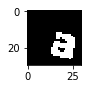

a a 0.518769


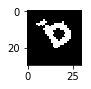

b b 0.856735


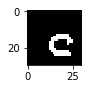

c c 0.991584


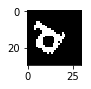

d d 0.759791


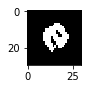

e e 0.727632


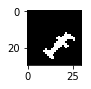

f i 0.294012


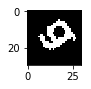

g g 0.414986


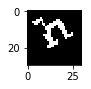

h h 0.96465


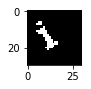

i i 0.788638


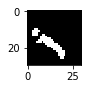

j j 0.644685


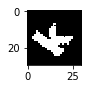

k k 0.976346


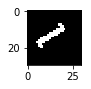

l l 0.670955


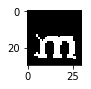

m m 0.998667


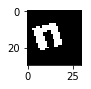

n n 0.996009


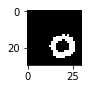

o o 0.733206


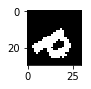

p p 0.927949


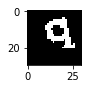

q q 0.541001


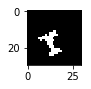

r r 0.602652


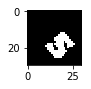

s s 0.157712


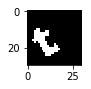

t t 0.480542


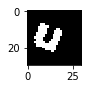

u u 0.966998


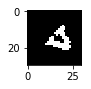

v v 0.311623


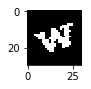

w w 0.99697


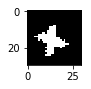

x x 0.99695


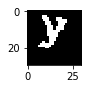

y y 0.999093


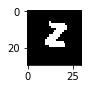

z z 0.97019


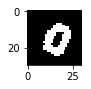

0 0 0.996127


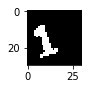

1 1 0.493241


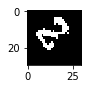

2 2 0.987043


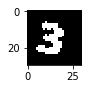

3 3 0.977459


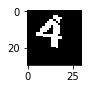

4 a 0.508546


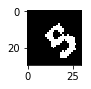

5 5 0.547029


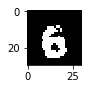

6 6 0.911671


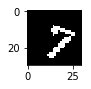

7 7 0.959936


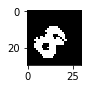

8 8 0.847319


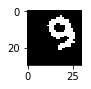

9 9 0.962788


In [623]:
for letter in ALPHABET:
    x, y = generate_example(letter)
    show(x)
    predicted_letter, confidence = predict(x)
    print(letter, predicted_letter, confidence)

In [625]:
def predict(image):
    image = resize(np.squeeze(image))
    batch = np.expand_dims(image, axis=0)
    proba = np.squeeze(model.predict_proba(batch, verbose=False), axis=0)
    i = np.argmax(proba)
    letter = class_to_letter[i]
    return letter, proba[i]

for captcha in captchas[:10]:
    image = preprocess(captcha)
    patches = segment(image)
    if len(patches) != 4:
        #print('pass: no good segmentation')
        continue
    text = ''
    confidence = 1.0
    for patch in patches:
        patch = patch_to_image(patch)
        letter, prob = predict(patch)
        #print(letter, prob)
        #if prob < 0.5:
        #    print('pass: not confident')
        #    break
        if letter in 'ijl1':
            #print('hard letter')
            break
        text += letter
        confidence *= prob
    if len(text) != 4:
        continue
    if confidence > 0.7:
        show(image)
        print('prediction:', text)
        print('confidence:', confidence)

In [ ]:
solutions = {}

In [643]:
try:
    seen = 0
    no_segmentation = 0
    hard_letter = 0
    low_confidence = 0
    while True:
        print('solutions:', len(solutions))
        print('seen:', seen)
        print('no_segmentation:', no_segmentation)
        print('hard_letter:', hard_letter)
        print('low_confidence:', low_confidence)
        print()
        captchas = get_captchas()
        for captcha in captchas:
            image = preprocess(captcha)
            patches = segment(image)
            if len(patches) != 4:
                no_segmentation += 1
                continue
            text = ''
            confidence = 1.0
            for patch in patches:
                patch = patch_to_image(patch)
                letter, prob = predict(patch)
                if letter in 'ijl1':
                    hard_letter += 1
                    break
                text += letter
                confidence *= prob
            if len(text) != 4:
                continue
            if confidence < 0.50:
                low_confidence += 1
                #if confidence > 0.3:
                #    show(image)
                #    print('prediction:', text)
                #    print('confidence:', confidence)
                continue
            solutions[captcha['name']] = (text, confidence)
        seen += len(captchas)
except KeyboardInterrupt:
    pass

solutions: 12517
seen: 0
no_segmentation: 0
hard_letter: 0
low_confidence: 0

solutions: 12618
seen: 1000
no_segmentation: 321
hard_letter: 259
low_confidence: 319

solutions: 12715
seen: 2000
no_segmentation: 658
hard_letter: 487
low_confidence: 657

solutions: 12812
seen: 3000
no_segmentation: 989
hard_letter: 736
low_confidence: 980

solutions: 12906
seen: 4000
no_segmentation: 1305
hard_letter: 996
low_confidence: 1310

solutions: 12996
seen: 5000
no_segmentation: 1652
hard_letter: 1262
low_confidence: 1607

solutions: 13103
seen: 6000
no_segmentation: 1994
hard_letter: 1513
low_confidence: 1907



In [644]:
submission = dict(solutions=[])
for name, (text, confidence) in solutions.items():
    submission['solutions'].append(dict(name=name, solution=text))
print('submitting {} solutions'.format(len(submission['solutions'])))
SUBMIT_URL = 'https://captcha.delorean.codes/u/{}/solution'.format(USERNAME)
response = requests.post(SUBMIT_URL, json=submission)

submitting 13121 solutions


In [645]:
print(response.text)

{
  "message": "Congratulations! Marty and Doc are free. You are winrar.", 
  "passcode": "Nov 17 4577 07:42 AM"
}

